In [1]:
import os, sys, subprocess
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Generate simple mock files to feed into fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign to estimate its efficiency.

The mock files generated in this notebook correspond to an idealized
distribution. All targets are initialized by construction on top of a fiber.

This idealized setup will allow us to explore the behaviour of fiberassign 
in a case where a perfect solution is known to exist: i. e. we know that 100% of the targets
can be assigned to a fiber.

This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [2]:
# setup working space
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign'
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)

In [3]:
# Function to generate ra, dec positions exactly on fiber positions
def ra_dec_around_positioners(tilera, tiledec, scatter_radius=0.0):
    fiberpos = desimodel.io.load_fiberpos()
    n_fibers = len(fiberpos)
    theta = np.random.random(n_fibers) * 2.0 * np.pi
    r = np.sqrt(scatter_radius * np.random.random(n_fibers))
    rand_x = r * np.cos(theta)
    rand_y = r * np.sin(theta)
    ra, dec = desimodel.focalplane.xy2radec(tilera, tiledec, fiberpos['X']+ rand_x, fiberpos['Y']+rand_y)
    return {'RA':ra, 'DEC':dec}

In [4]:
# Function to generate the target files in the right format for fiberassign
def generate_targets_around_positioners(tiles, scatter_radius=0.0):
    """
    Generate points around positioners
    """
    ra_dec_list = {}
    n_tiles = len(tiles)
    for i in range(n_tiles):
        ra_dec_list[i] = ra_dec_around_positioners(tiles[i]['RA'], tiles[i]['DEC'], scatter_radius=scatter_radius)
   
    # count the number of targets
    n = 0
    for i in range(n_tiles):
        n += len(ra_dec_list[i]['RA'])

    #- Iterate if needed to get unique TARGETIDs
    while True:
        targetids = np.random.randint(0, 2**62-1, n)
        if len(set(targetids)) == n:
            break

    #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = np.zeros(n)
    targets['DEC'] = np.zeros(n)
    targets['DESI_TARGET'] = np.zeros(n)
    targets['BGS_TARGET'] = np.zeros(n)
    targets['MWS_TARGET'] = np.zeros(n)
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    
    n_tot = 0
    for i in range(n_tiles):
        n_in = len(ra_dec_list[i]['RA'])
        targets['RA'][n_tot:n_tot+n_in] = ra_dec_list[i]['RA'][:]
        targets['DEC'][n_tot:n_tot+n_in] = ra_dec_list[i]['DEC'][:]
        n_tot += n_in
        
    
    return targets

In [5]:
# generate random targets with a desired number density
def generate_random_targets(density, tiles):
    #- Get basic bounds; don't worry about RA wraparound for this example
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    ramin = np.min(tiles['RA'] - tile_radius*np.cos(np.radians(tiles['DEC'])))
    ramax = np.max(tiles['RA'] + tile_radius*np.cos(np.radians(tiles['DEC'])))
    decmin = np.min(tiles['DEC']) - tile_radius
    decmax = np.max(tiles['DEC']) + tile_radius
    
    area = (ramax-ramin) * np.degrees((np.sin(np.radians(decmax)) - np.sin(np.radians(decmin))))
    n = int(area*density)

    #- Iterate if needed to get unique TARGETIDs
    while True:
        targetids = np.random.randint(0, 2**62-1, n)
        if len(set(targetids)) == n:
            break

    #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = np.random.uniform(ramin, ramax, n)
    phimin = np.radians(90-decmin)
    phimax = np.radians(90-decmax)
    targets['DEC'] = 90-np.degrees(np.arccos(np.random.uniform(np.cos(phimin), np.cos(phimax), n)))
    targets['DESI_TARGET'] = np.zeros(n)
    targets['BGS_TARGET'] = np.zeros(n)
    targets['MWS_TARGET'] = np.zeros(n)
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    
    #- Trim to targets that are covered by a tile
    ii = desimodel.footprint.is_point_in_desi(tiles, targets['RA'], targets['DEC'])
    targets = targets[ii]
    
    return targets

In [6]:
# We generate tiles dithered by 0.001 the tile radius

dither = 0.001
ntiles = 5
tiles = Table()
tile_radius = desimodel.focalplane.get_tile_radius_deg()
tiles['TILEID'] = np.arange(ntiles, dtype=int)
tiles['RA'] = 5 + np.arange(ntiles)*dither*tile_radius
tiles['DEC'] = np.zeros(ntiles)
tiles['PASS'] = np.zeros(ntiles)
tiles['OBSCONDITIONS'] = np.ones(ntiles) * obsconditions.DARK
tiles['IN_DESI'] = np.ones(ntiles)
tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
tiles.write('tiles.fits', format='fits', overwrite=True)

In [7]:
# We generate targets on the tiles produced before

targets = generate_targets_around_positioners(tiles)
n = len(targets)
targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(n) * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(n)
targets.meta['EXTNAME'] = 'MTL'
targets.write('mtl.fits', overwrite=True)

In [8]:
#- Sky targets at 4x the density of fibers

fiber_density = 5000 / 7.5
sky_density = 4*fiber_density
sky = generate_random_targets(sky_density, tiles)
nsky = len(sky)
sky['DESI_TARGET'] = desi_mask.SKY
sky['OBSCONDITIONS'] = np.ones(nsky) * obsconditions.mask('DARK|GRAY|BRIGHT')
sky.meta['EXTNAME'] = 'SKY'
sky.write('sky.fits', overwrite=True)

In [9]:
# - Standard star targets
std_density = 50
stdstars = generate_random_targets(std_density, tiles)
nstd = len(stdstars)
stdstars['SUBPRIORITY'] = np.random.uniform(0, 1, nstd)
stdstars['DESI_TARGET'] = desi_mask.STD_FAINT
stdstars['OBSCONDITIONS'] = np.ones(nstd) * obsconditions.DARK
stdstars.meta['EXTNAME'] = 'STD'
stdstars.write('stdstars.fits', overwrite=True)

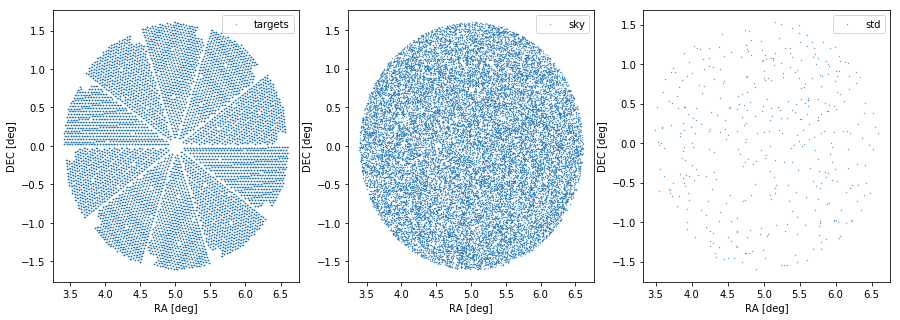

In [10]:
# This is how the targets, sky, standards look like
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(targets['RA'], targets['DEC'], s=0.1, label='targets')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend()

plt.subplot(1,3,2)
plt.scatter(sky['RA'], sky['DEC'], s=0.1, label='sky')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend()


plt.subplot(1,3,3)
plt.scatter(stdstars['RA'], stdstars['DEC'], s=0.1, label='std')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend()

In [11]:
# In this run we explicitly ask not to assign any sky or stdstars, 
# in real life those have to be used, we only want to check that 
# fiberassign is able to assign a fiber on top of every target, as expected
cmd = 'fiberassign --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd += ' --nstarpetal 0'
cmd += ' --nskypetal 0'
cmd = cmd.format(outdir=outdir)

In [12]:
#- Cleanup old files if needed
for tileid in tiles['TILEID']:
    tilefile = '{}/tile_{:05d}.fits'.format(outdir, tileid)
    if os.path.exists(tilefile):
        os.remove(tilefile)

#- TODO: capture stderr/stdout to a log
print('RUNNING: '+cmd)
err = subprocess.call(cmd.split())
print(err)
assert err == 0

RUNNING: fiberassign --mtl mtl.fits --stdstar stdstars.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/ --nstarpetal 0 --nskypetal 0
0


In [13]:
!ls output

tile_00000.fits  tile_00002.fits  tile_00004.fits
tile_00001.fits  tile_00003.fits


Text(0.5,1,'Targets assigned to fibers')

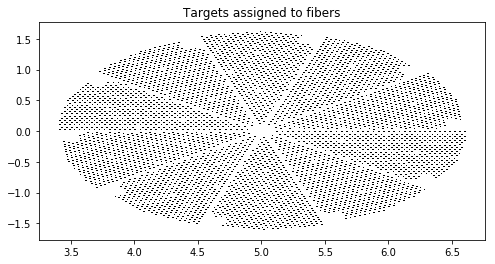

In [14]:
# Gather all the outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile_{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, 'FIBERASSIGN'))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(8,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
# plot_tiles(tiles)

Text(0.5,1,'Targets not assigned to fibers')

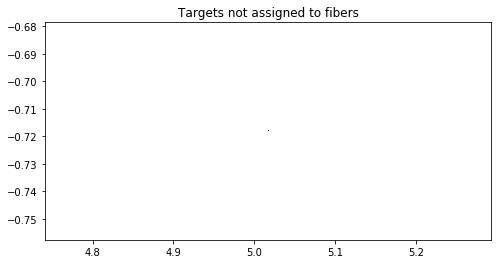

In [15]:
plt.figure(figsize=(8,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets not assigned to fibers')

In [16]:
# All targets were assigned, except one
print(np.count_nonzero(isAssigned), np.count_nonzero(~isAssigned))

# This unassigned targets corresponds to the first target in the list
print(targets['RA'][0], targets['DEC'][0])

24999 1
5.01686849365 -0.718073012852
